In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
def convert_dtype(x):
    try:
        return float(x)   
    except ValueError:        
        return np.nan

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
os.chdir("./drive/MyDrive/")

In [4]:
df = pd.read_csv("household_power_consumption.txt",
                 sep=";", 
                 parse_dates={'index':['Date','Time']},
                 converters={"Global_active_power": convert_dtype,
                 "Global_reactive_power": convert_dtype,
                 "Voltage": convert_dtype,
                 "Global_intensity": convert_dtype,
                 "Sub_metering_1": convert_dtype,
                 "Sub_metering_2": convert_dtype},
                 index_col = "index"
                 )
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
index,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [10]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [11]:
df.shape

(2075259, 7)

In [5]:
def fill_mean(df, column):
    mean = df[column].mean()
    df[column] = df[column].fillna(mean)
    
    return df[column]

for i in df.columns:
    fill_mean(df, i)

In [9]:
df.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [6]:
# Resampling to a daily sampling rate
daily_df = df.resample("D").sum()
daily_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
index,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [28]:
daily_df.shape

(1457, 7)

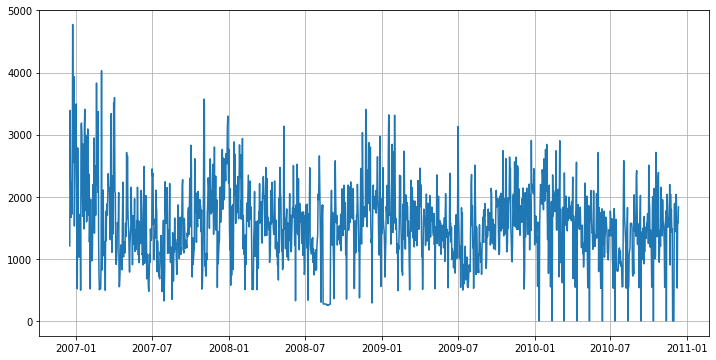

In [8]:
# Plotting the daily_global_active_power over time
plt.figure(figsize=(12, 6))
plt.plot(daily_df.index, daily_df["Global_active_power"])
plt.grid()

In [30]:
# Pearson correlation coefficient between global_active_power and global_reactive_power
round(df["Global_active_power"].corr(df["Global_reactive_power"], method="pearson"), 2)

0.25

In [31]:
# Pearson correlation coefficient between global_intensity and voltage
round(df["Voltage"].corr(df["Global_intensity"], method="pearson"), 2)

-0.41

In [7]:
daily_df.reset_index(inplace=True)
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457 entries, 0 to 1456
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   index                  1457 non-null   datetime64[ns]
 1   Global_active_power    1457 non-null   float64       
 2   Global_reactive_power  1457 non-null   float64       
 3   Voltage                1457 non-null   float64       
 4   Global_intensity       1457 non-null   float64       
 5   Sub_metering_1         1457 non-null   float64       
 6   Sub_metering_2         1457 non-null   float64       
 7   Sub_metering_3         1457 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 91.2 KB


In [8]:
daily_df1 = daily_df[["index", "Global_active_power"]]
daily_df1 = daily_df1.rename(columns={"index": "ds", "Global_active_power": "y"})

In [36]:
daily_df1.shape

(1457, 2)

In [37]:
daily_df1.head()

,ds,y
0,2006-12-16,1209.176
1,2006-12-17,3390.460
2,2006-12-18,2203.826
3,2006-12-19,1666.194
4,2006-12-20,2225.748


In [9]:
X_train_daily1 = daily_df1[:-365]
X_test_daily1 = daily_df1[-365:]

In [10]:
from fbprophet import Prophet

model = Prophet()
model.fit(X_train_daily1)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [11]:
# To predict for the next 365 days
future = model.make_future_dataframe(periods=365, freq="D")
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2006-12-16,1652.571508,1408.227848,2863.240587,1652.571508,1652.571508,493.008951,493.008951,493.008951,149.605738,149.605738,149.605738,343.403213,343.403213,343.403213,0.0,0.0,0.0,2145.580459
1,2006-12-17,1652.402305,1417.383670,2862.858485,1652.402305,1652.402305,496.504609,496.504609,496.504609,138.197459,138.197459,138.197459,358.307150,358.307150,358.307150,0.0,0.0,0.0,2148.906914
2,2006-12-18,1652.233101,1175.252495,2650.894533,1652.233101,1652.233101,272.523643,272.523643,272.523643,-101.330342,-101.330342,-101.330342,373.853985,373.853985,373.853985,0.0,0.0,0.0,1924.756744
3,2006-12-19,1652.063898,1321.957429,2734.113941,1652.063898,1652.063898,391.332085,391.332085,391.332085,1.644273,1.644273,1.644273,389.687812,389.687812,389.687812,0.0,0.0,0.0,2043.395983
4,2006-12-20,1651.894694,1285.595173,2766.521623,1651.894694,1651.894694,368.307370,368.307370,368.307370,-37.130219,-37.130219,-37.130219,405.437589,405.437589,405.437589,0.0,0.0,0.0,2020.202064


In [59]:
forecast.shape

(1457, 19)

In [12]:
y_true = X_train_daily1["y"]
y_pred = forecast["yhat"][:-365]

In [25]:
y_true.shape

(365,)

In [61]:
X_train_daily1.head()

,ds,y
0,2006-12-16,1209.176
1,2006-12-17,3390.460
2,2006-12-18,2203.826
3,2006-12-19,1666.194
4,2006-12-20,2225.748


In [13]:
# mean absolute percentage error

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape

37.89883913311757

In [17]:
# root mean squared erroe(RMSE) & mean absolute error (MAE) for time series
from sklearn.metrics import mean_absolute_error, mean_squared_error

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print("rmse:", rmse)

rmse: 556.2465300156035


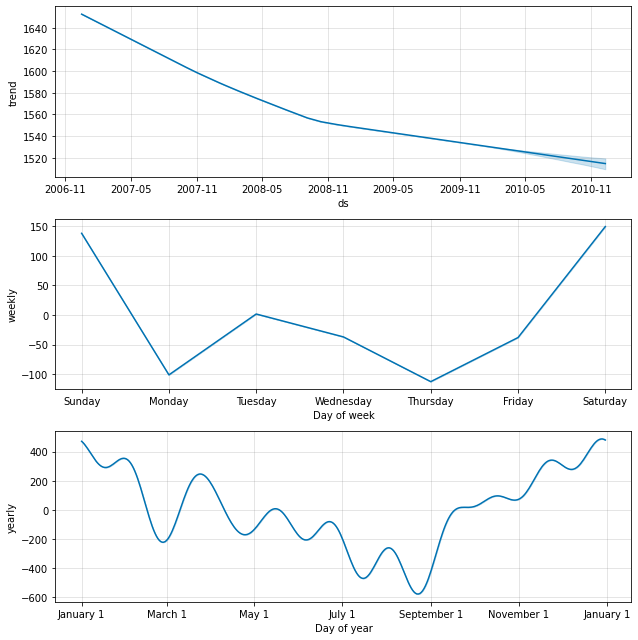

In [18]:
model.plot_components(forecast)
plt.show()

In [19]:
multi_df = daily_df.copy()

multi_df = multi_df.rename(columns={"index": "ds", 
                                    "datetime": "ds", 
                                    "Global_active_power": "y",
                                    "Global_reactive_power": "add1",
                                    "Voltage": "add2",
                                    "Global_intensity": "add3",
                                    "Sub_metering_1": "add4",
                                    "Sub_metering_2": "add5",
                                    "Sub_metering_3": "add6"})

In [47]:
multi_df.head()

,ds,y,add1,add2,add3,add4,add5,add6
0,2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
1,2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2,2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
3,2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
4,2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [20]:
X_train_multi = multi_df[:-365]
X_test_multi = multi_df[-365:]

In [21]:
model_multi = Prophet()
model_multi.add_regressor('add1')
model_multi.add_regressor('add2')
model_multi.add_regressor('add3')
model_multi.add_regressor('add4')
model_multi.add_regressor('add5')
model_multi.add_regressor('add6')

In [22]:
model_multi.fit(X_train_multi)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
future_multi = model_multi.make_future_dataframe(periods=365,freq='D')
future_multi['add1'] = multi_df['add1'].values
future_multi['add2'] = multi_df['add2'].values
future_multi['add3'] = multi_df['add3'].values
future_multi['add4'] = multi_df['add4'].values
future_multi['add5'] = multi_df['add5'].values
future_multi['add6'] = multi_df['add6'].values
forecast = model_multi.predict(future_multi)

In [24]:
y_true = X_train_multi["y"]
y_pred = forecast["yhat"][:-365]

In [25]:
# mean absolute percentage error

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape

0.8096982994556454

In [26]:
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print("rmse:", rmse)

rmse: 14.899482265157861


[]

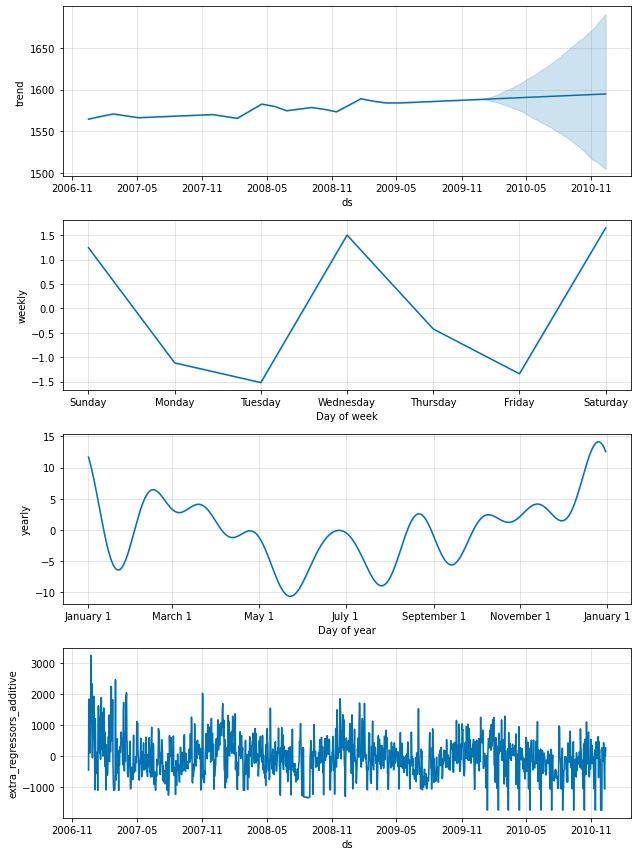

In [28]:
model_multi.plot_components(forecast)
plt.plot()